In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob
import pprint
import copy
import shutil
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from collections import OrderedDict

from dataset import *
from runner import ExptRunner
from runner import ExptEvaluator
from networks.imageencoder import *
from networks.imagedecoder import *
from networks.DenseAutoEncoder import DenseAutoEncoder
from networks.composedautoencoder import ComposedAutoEncoder
from networks.ConvVae import ConvVae
from networks.vae import VAE
from networks.dense import *
from networks.lossfunctions import *
from networks.reacherspecial import *
from helpers import *
import utils
import plottinghelpers
import simplereacherdimensions
import simplereacheradapters
from env.simulator import simulator, evaluator

In [5]:
def random_ctl(use_seed=0):
    seed = use_seed if use_seed else random.randint(1,1000000)
    print(f"Using seed: {seed}")

    # python RNG
    random.seed(seed)

    # pytorch RNGs
    torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    if use_seed:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark     = False

    # numpy RNG
    np.random.seed(seed)

    return seed

In [3]:
import warnings
warnings.filterwarnings("ignore", category=torch.serialization.SourceChangeWarning)

In [4]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf)

In [6]:
torch.set_printoptions(sci_mode=False)

In [7]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [8]:
print (device)

cuda:3


In [9]:
cpu = torch.device('cpu')
cpu

device(type='cpu')

In [10]:
# if torch.cuda.is_available():
#     print (torch.cuda.current_device())
#     torch.cuda.set_device(device)
#     print (torch.cuda.current_device())

In [11]:
root_folder = 'data/simple_reacher/training'
# number_of_trajectories = 10
number_of_trajectories = 5000

In [12]:
start = time.time()
train_data = SimpleReacherOnDemandDataset(root_folder, range(4750), device=device)
test_data = SimpleReacherOnDemandDataset(root_folder, range(4750, 5000), device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 7.377913236618042 sec


In [13]:
print (len(train_data))
print (len(test_data))
print (train_data.trajectory_data.device)
print (test_data.trajectory_data.device)

103274
5399
cuda:2
cuda:2


In [14]:
def run_expts(train_epochs):
    for i in range(len(expts)):
        arg_lists = expts[i]
        cons_args = arg_lists[0]
        train_args = {}
        if (len(arg_lists)) > 1:
            train_args = arg_lists[1]
        test_args = {}
        if (len(arg_lists)) > 2:
            test_args = arg_lists[2]
        
        runner = ExptRunner(train_data=train_data, test_data=test_data, device=device, **cons_args)
        print ("Experiment logs folder: {}".format(runner.log_folder))
        with open(runner.log_folder + '/expt.txt', 'w') as f:
            f.write(pprint.pformat(arg_lists))
        runner.train(train_epochs, **train_args)

In [15]:
# First number represents the number of layers, second : channels per each layer, third : kernel size
img_auto_encoder = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[16, 16, 16, 16],
                                               useMaxPool=True,
                                               device=device)

img_auto_encoder_5_16_7 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[16, 16, 16, 16, 16],
                                               useMaxPool=True,
                                               device=device,
                                               kernel_size=7)

img_auto_encoder_5_32_7 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[32, 32, 32, 32, 32],
                                               useMaxPool=True,
                                               device=device,
                                               kernel_size=7)
img_auto_encoder_5_16_5 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[16, 16, 16, 16, 16],
                                               useMaxPool=True,
                                               device=device,
                                               kernel_size=5)

img_auto_encoder_5_32_5 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[32, 32, 32, 32, 32],
                                               useMaxPool=True,
                                               device=device,
                                               kernel_size=5)
img_encoder_5_32_5 = lambda: ImageEncoderFlatInput(img_res=simplereacherdimensions.img_res,
                                               input_channels=1,
                                               layers_channels=[32, 32, 32, 32, 32],
                                               prefix='enc',
                                               useMaxPool=True,
                                               addFlatten=True,
                                               kernel_size=5)

In [16]:
def load_pretrained(folder):
    chkptFile = os.path.join('runs', folder, 'train_checkpoint.tar')
    return torch.load(chkptFile, map_location=device)['model']

pretrain_image_auto_enc = load_pretrained('AutoEncoders/08-13/run2-img-auto-encoder/08-13-21-59-10-ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_32_5-L1')
pretrain_policy = load_pretrained('Policies/08-19/08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1')
pretrain_img_to_env = load_pretrained('AutoEncoders/08-12/run1-img-to-env/08-12-18-44-36-ImageToEnv-Reacher-Conv4Dense3-MSE/')

In [17]:
next(pretrain_image_auto_enc.encoder.net[0].parameters()).device

device(type='cuda', index=2)

In [18]:
img_layers = [16,16,16,16]
# z_dim = 4096 # 16 * 26 * 16 , This should be set based on above img_layers
z_dim = 2048
env_layers = [6, 128, 512, z_dim]
in_channels = 1
img_encoder = lambda: ImageEncoderFlatInput(in_channels, img_layers, 'imgenc', useMaxPool=True, addFlatten=True, img_res=simplereacheradapters.img_res)
# img_decoder = lambda: ImageDecoderFlatInput(z_dim, list(reversed(img_layers)), in_channels, 'imgdec', useSigmoid=True)
# env_encoder = lambda: Dense(env_layers, use_last_act=False, prefix='envenc')
env_decoder = lambda: Dense(list(reversed(env_layers)), last_act='sigmoid', prefix='envdec')
combined = lambda l1, l2: nn.Sequential(OrderedDict([
                              ('EncNet', l1()),
                              ('DecNet', l2()),
                            ]))

In [19]:
def env_enc_pretrained_img_dec():
    net = combined(env_encoder, img_decoder).to(device)
    load_mapped_state_dict(net, pretrain_imgEncDec, 'DecNet.net.imgdec', 'decoder.net.dec')
    return net

def pretrained_img_enc_env_dec(i_encoder, e_decoder):
    net = combined(i_encoder, e_decoder).to(device)
    load_mapped_state_dict(net, pretrain_image_auto_enc, 'EncNet.net.imgenc', 'encoder.net.enc')
    return net

def img_enc_env_dec_from_pretrained():
    net = combined(img_encoder, env_decoder).to(device)
    load_mapped_state_dict(net, pretrain_imgEncDec, 'EncNet.net.imgenc', 'encoder.net.enc')
    load_mapped_state_dict(net, pretrain_envEncDec, 'DecNet.net.envdec_fc0', 'decoder.dec_fc1') # Hacky
    return net

def latent_policy_from_latent(latentReference, policy=None, fix_indices=[0]):
    latent = copy.deepcopy(latentReference)
    if not policy:
        policy = Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol')
    configure_net_training(latent, False)
    net = LatentPolicyNet(latent=latent, policy=policy).to(device)
    return net

def latent_policy_fixed_img_enc_pol_train_env_dec(latentFilter=None, policy=pretrain_policy, e_decoder=env_decoder, i_encoder=img_encoder):
    latent = pretrained_img_enc_env_dec(i_encoder, e_decoder)
    policy = copy.deepcopy(policy)
    configure_net_training(policy, False)
    configure_net_training(latent[0], False)
    return LatentPolicyNet(latent=latent, policy=policy, latentFilter=latentFilter).to(device)

def latentFilter_gt_x_latent_y(data, latent_output):
    return torch.cat((Xt_scaled_adapter(data), latent_output[:, 2:]), dim=1)

def image_to_env(conv, dense):
    return combined(conv, dense)

In [17]:
net = latent_policy_fixed_img_enc_pol_train_env_dec(i_encoder=img_encoder_5_32_5)

In [18]:
r = verify_mapped_state_dict(net, pretrain_image_auto_enc, 'EncNet.net.imgenc', 'encoder.net.enc')
if not r:
    print ('Verificiation failed!')

In [24]:
net_func = lambda: Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol')

In [35]:
random_ctl()
n1 = net_func()
n2 = net_func()
n3 = net_func()

Using seed: 170775


In [36]:
print (next(n1.parameters()) - next(n2.parameters()))
print (next(n3.parameters()) - next(n2.parameters()))

tensor([[ 0.5339,  0.3110,  0.0813,  0.5322, -0.2684,  0.2784],
        [-0.1472,  0.2033,  0.0532, -0.5745,  0.1935, -0.1082],
        [ 0.7818, -0.4952, -0.0882, -0.6592, -0.2292,  0.1984],
        [-0.4735, -0.1918, -0.2000, -0.6809, -0.2231,  0.2732],
        [ 0.5770,  0.1979, -0.0383,  0.2161, -0.4062,  0.3374],
        [ 0.3476,  0.2444, -0.1085,  0.4199,  0.1277,  0.1819],
        [ 0.1227, -0.1468,  0.4102,  0.0791, -0.3946,  0.0340],
        [ 0.6846,  0.1445,  0.0192, -0.0246,  0.3678,  0.0091],
        [ 0.3533, -0.3055, -0.6558,  0.4971,  0.0929, -0.6355],
        [ 0.0736, -0.3524,  0.1731, -0.1522, -0.1340,  0.2812],
        [-0.1125, -0.3937, -0.3057, -0.2665,  0.3049,  0.1721],
        [ 0.1493, -0.1292,  0.0354, -0.3222,  0.2656, -0.0201],
        [ 0.2375,  0.5806, -0.6026, -0.2986, -0.3561,  0.0781],
        [ 0.7646,  0.2990,  0.3237, -0.4158, -0.4843, -0.1068],
        [ 0.2481, -0.2301, -0.1512,  0.2140, -0.3632, -0.5072],
        [ 0.0386, -0.3458, -0.2395,  0.2

In [37]:
expts = [
#   Fixed image encoder, policy, train decoder from encoder output to policy input
#     [{
#         "expt_prefix":'FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense4-L1',
#         "net_func": lambda: latent_policy_fixed_img_enc_pol_train_env_dec(i_encoder=img_encoder_5_32_5),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Train policy using fixed Image To Env function
#     [{
#         "expt_prefix":'FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE',
#         "net_func": lambda: latent_policy_from_latent(pretrain_img_to_env),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Image To Env function
#     [{
#         "expt_prefix":'ImageToEnv-Reacher-Conv4Dense3-MSE',
#         "net_func": lambda: image_to_env(img_encoder, env_decoder),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.XtYt_scaled_adapter,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Policy
    [{
        "expt_prefix":'Policy-Reacher-Dense4WithTanh-L1',
        "net_func": lambda: Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol'),
        "data_adapter_func": simplereacheradapters.XtYt_scaled_adapter,
        "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
        "loss_adapter_func": l1_loss_adapter,
     },
    {
    },
    {
        "loss_adapter": l1_loss_adapter
    }],
#     [{
#         "expt_prefix":'Policy-Reacher-Dense4WithTanh-mse',
#         "net_func": lambda: Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol'),
#         "data_adapter_func": simplereacheradapters.XtYt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'Policy-Reacher-Dense4WithSigmoid-L1',
#         "net_func": lambda: Dense(layer_dims=[6, 16, 16, 3], last_act='sigmoid', prefix='pol'),
#         "data_adapter_func": simplereacheradapters.XtYt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Image autoencoder
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder4-MSE',
#         "net_func": img_auto_encoder,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder4-L1',
#         "net_func": img_auto_encoder,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_16_7-L1',
#         "net_func": img_auto_encoder_5_16_7,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_32_7-L1',
#         "net_func": img_auto_encoder_5_32_7,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_16_5-L1',
#         "net_func": img_auto_encoder_5_16_5,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_32_5-L1',
#         "net_func": img_auto_encoder_5_32_5,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
]

In [ ]:
train_epochs = 100
random_ctl()
run_expts(train_epochs)

Using seed: 664038
Experiment logs folder: runs/08-22-10-38-38-Policy-Reacher-Dense4WithTanh-L1


In [35]:
chkpt = torch.load('runs/AutoEncoders/08-13/run2-img-auto-encoder/08-13-17-04-33-ImageAutoEncoder-Reacher-ComposedAutoEncoder4-MSE/train_checkpoint.tar', map_location=device)

In [36]:
next(chkpt['model'].parameters()).device

device(type='cuda', index=3)

In [26]:
for p in e.net.parameters():
    if p.device != device:
        print (p.device)

In [32]:
start = time.time()

for chkpt_file in utils.enumerate_files(rootdir='runs/AutoEncoders/08-13'):
    e = ExptEvaluator(chkpt_file, train_data, test_data, device)
    e.test()
    print ('Done with checkpoint file {}'.format(chkpt_file))

print ("Time Taken: {} sec".format(time.time() - start))

Writing eval metrics of shape: torch.Size([5399, 1])
Writing eval metrics of shape: torch.Size([103274, 1])
Done with checkpoint file runs/AutoEncoders/08-13/run2-img-auto-encoder/08-13-17-04-33-ImageAutoEncoder-Reacher-ComposedAutoEncoder4-MSE/train_checkpoint.tar
Writing eval metrics of shape: torch.Size([5399, 1])
Writing eval metrics of shape: torch.Size([103274, 1])
Done with checkpoint file runs/AutoEncoders/08-13/run2-img-auto-encoder/08-13-21-59-10-ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_32_5-L1/train_checkpoint.tar
Time Taken: 281.5692753791809 sec


In [41]:
plottinghelpers.save_all_plots_img_auto_encoder_run(rootdir='runs/AutoEncoders/09-03')

Processing folder : runs/AutoEncoders/09-03/09-03-11-00-53-ImageAutoEncoder-Reacher-ComposedAutoEncoder4-L1
Done


In [37]:
start = time.time()

plottinghelpers.generate_img_reconstructions(
    rootdir='runs/AutoEncoders/08-13',
    device=device, train_data=train_data, test_data=test_data,
    img_res=simplereacherdimensions.img_res)

print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 2.766228437423706 sec


In [12]:
start = time.time()
train_traj_data = SimpleReacherTrajectoryDataset(root_folder, range(500), device=cpu) #only a subset of training_data
test_traj_data = SimpleReacherTrajectoryDataset(root_folder, range(4750, 5000), device=cpu)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 0.00010561943054199219 sec


In [33]:
test_traj_data[0]['states']

tensor([[-0.0387,  0.0201,  0.0559,  0.6886, -1.8998,  0.7256,  0.0212, -0.0462,
         -0.0826],
        [-0.0179, -0.0251, -0.0228,  0.6886, -1.8998,  0.7256,  0.0072, -0.0191,
          0.0033],
        [-0.0108, -0.0438, -0.0195,  0.6886, -1.8998,  0.7256,  0.0319, -0.0847,
          0.0339],
        [ 0.0205, -0.1242,  0.0137,  0.6886, -1.8998,  0.7256,  0.0324, -0.0886,
          0.0345],
        [ 0.0523, -0.2078,  0.0475,  0.6886, -1.8998,  0.7256,  0.0324, -0.0894,
          0.0345],
        [ 0.0841, -0.2920,  0.0814,  0.6886, -1.8998,  0.7256,  0.0324, -0.0896,
          0.0345],
        [ 0.1158, -0.3763,  0.1153,  0.6886, -1.8998,  0.7256,  0.0324, -0.0896,
          0.0345],
        [ 0.1476, -0.4606,  0.1491,  0.6886, -1.8998,  0.7256,  0.0324, -0.0896,
          0.0345],
        [ 0.1794, -0.5450,  0.1830,  0.6886, -1.8998,  0.7256,  0.0324, -0.0896,
          0.0345],
        [ 0.2112, -0.6293,  0.2169,  0.6886, -1.8998,  0.7256,  0.0324, -0.0896,
          0.0345],


In [58]:
pretrained_net = nn.Sequential(OrderedDict([
                      ('ItoY', pretrain_img_to_env),
                      ('pol', pretrain_policy),
                    ])).to(cpu)
pretrained_net = pretrained_net.eval()

In [42]:
start = time.time()

for chkpt_file in utils.enumerate_files(rootdir='runs/Policies/08-21'):
    print ('Start processing checkpoint file {}'.format(chkpt_file))
    policy_takes_image=False # DO NOT FORGET TO SET THIS
    e = evaluator(chkpt_file, cpu, policy_takes_image=policy_takes_image, persist_to_disk=True, 
                  op_reverse_adapter=simplereacheradapters.Ut_scaled_adapter_zero_center_reverse,
                  ip_adapter=simplereacheradapters.XtYt_scaled_adapter_eval)
    e.evaluate(test_traj_data, target_folder='TestSet_Evaluations')
    e.evaluate(train_traj_data, target_folder='SmallTrainSet_Evaluations')
    print ('')

print ("Time Taken: {} sec".format(time.time() - start))

Start processing checkpoint file runs/Policies/08-21/08-21-19-09-09-Policy-Reacher-Dense4WithTanh-L1/train_checkpoint.tar
-------------------------------------------------------------
runs/Policies/08-21/08-21-19-09-09-Policy-Reacher-Dense4WithTanh-L1
-------------------------------------------------------------
Number of Trajectories Ended up Within Goal Region (Goal Loss <= 0.009999999776482582): 74.0
Average Policy L1 Loss: 0.01241355575621128
Average Trajectory Loss: 0.060638196766376495
Average Goal Loss: 0.022836562246084213
Average Combined State Loss: 0.032450828701257706

Least Policy L1 Error: Index = 20, Value = 0.0045960755087435246
Least Trajectory Error: Index = 20, Value = 0.011264368891716003
Least Goal Error: Index = 235, Value = 0.00171917793340981

Highest Policy L1 Error: Index = 49, Value = 0.030079428106546402
Highest Trajectory Error: Index = 74, Value = 0.1473257839679718
Highest Goal Error: Index = 219, Value = 0.15027548372745514
------------------------------

In [43]:
plottinghelpers.save_all_plots_policy_rollout_run(rootdir='runs/Policies/08-21')

Processing folder : runs/Policies/08-21/08-21-19-09-09-Policy-Reacher-Dense4WithTanh-L1
Processing folder : runs/Policies/08-21/08-22-10-38-38-Policy-Reacher-Dense4WithTanh-L1
Done


In [30]:
start = time.time()

for chkpt_file in utils.enumerate_files(rootdir='runs/AutoEncoders'):
#     folder = os.path.join(os.path.dirname(chkpt_file), 'TestSet_Evaluations')
#     if os.path.exists(folder):
#         print ('Deleting folder : {}'.format(folder))
#         shutil.rmtree(folder, ignore_errors=True)
    # os.rename(os.path.dirname(chkpt_file) + '/Evaluations', os.path.dirname(chkpt_file) + '/Old_Evaluations')
    print ('Processing checkpoint file: {}'.format(chkpt_file))
    cpu_chkpt = torch.load(chkpt_file, map_location=cpu)
    # os.rename(chkpt_file, chkpt_file+'.bkp')
    torch.save(cpu_chkpt, chkpt_file)

print ("Time Taken: {} sec".format(time.time() - start))

Processing checkpoint file: runs/AutoEncoders/08-10/08-10-20-54-33-ImageAutoEncoder-Reacher-ComposedAutoEncoder4-MSE/train_checkpoint.tar
Processing checkpoint file: runs/AutoEncoders/08-10/08-10-21-23-45-ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_16_7-L1/train_checkpoint.tar
Processing checkpoint file: runs/AutoEncoders/08-10/08-10-22-03-54-ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_32_7-L1/train_checkpoint.tar
Processing checkpoint file: runs/AutoEncoders/08-10/08-10-23-00-44-ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_16_5-L1/train_checkpoint.tar
Processing checkpoint file: runs/AutoEncoders/08-10/08-10-23-31-30-ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_32_5-L1/train_checkpoint.tar
Processing checkpoint file: runs/AutoEncoders/08-10/08-13-15-53-41-ImageAutoEncoder-Reacher-ComposedAutoEncoder4-L1/train_checkpoint.tar
Processing checkpoint file: runs/AutoEncoders/08-11/run2-image-to-env/08-11-17-28-18-ImageToEnv-Reacher-Conv4Dense3-MSE/train_checkpoint.tar
Processing c

In [27]:
traj_data = SimpleReacherTrajectoryDataset(root_folder, range(5000), device=cpu)
count = 0
max_dev = 0
for tId in range(len(traj_data)):
    last_row = traj_data[tId][states_key][-1, :]
    goal_dev_gt = F.l1_loss(last_row[:3], last_row[3:6])
    if goal_dev_gt > 0.01:
        # print (goal_dev_gt)
        max_dev = max(max_dev, goal_dev_gt)
        count += 1
print ('Total trajectories where there is goal deviation in ground truth : {}'.format(count))
print ('Maximum goal deviation in ground truth : {}'.format(max_dev))

Total trajectories where there is goal deviation in ground truth : 229
Maximum goal deviation in ground truth : 0.033625187543541234


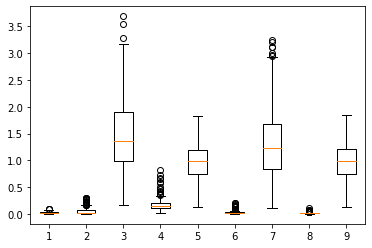

From left to right:
08-11-15-10-38-Policy-Reacher-Dense4WithTanh-L1
08-11-15-45-41-Policy-Reacher-Dense4WithTanh-mse
08-13-10-45-12-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv4Dense3-MSE
08-13-11-15-00-FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE
08-14-08-54-19-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense3-MSE
08-17-11-09-51-Policy-Reacher-Dense4WithTanh-mse
08-17-14-49-24-Policy-Reacher-Dense4WithSigmoid-L1
08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1
08-19-20-24-49-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense4-L1


In [25]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation'
)

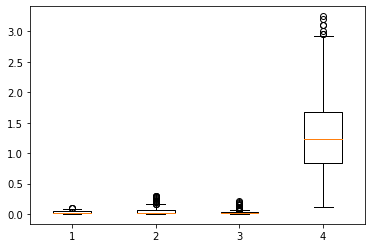

From left to right:
08-11-15-10-38-Policy-Reacher-Dense4WithTanh-L1
08-11-15-45-41-Policy-Reacher-Dense4WithTanh-mse
08-17-11-09-51-Policy-Reacher-Dense4WithTanh-mse
08-17-14-49-24-Policy-Reacher-Dense4WithSigmoid-L1


In [27]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
        '08-11-15-10-38-Policy-Reacher-Dense4WithTanh-L1',
        '08-11-15-45-41-Policy-Reacher-Dense4WithTanh-mse',
        '08-17-11-09-51-Policy-Reacher-Dense4WithTanh-mse',
        '08-17-14-49-24-Policy-Reacher-Dense4WithSigmoid-L1'
    ]
)

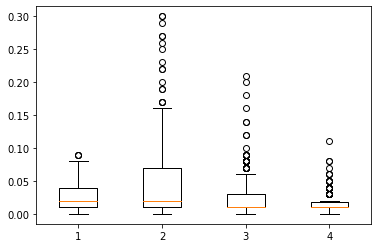

From left to right:
08-11-15-10-38-Policy-Reacher-Dense4WithTanh-L1
08-11-15-45-41-Policy-Reacher-Dense4WithTanh-mse
08-17-11-09-51-Policy-Reacher-Dense4WithTanh-mse
08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1


In [28]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
        '08-11-15-10-38-Policy-Reacher-Dense4WithTanh-L1', 
        '08-11-15-45-41-Policy-Reacher-Dense4WithTanh-mse',
        '08-17-11-09-51-Policy-Reacher-Dense4WithTanh-mse',
        '08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1'
    ]
)

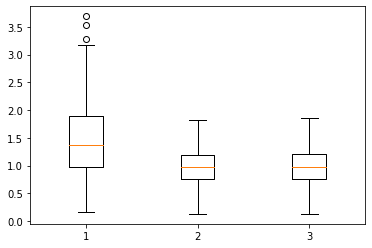

From left to right:
08-13-10-45-12-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv4Dense3-MSE
08-14-08-54-19-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense3-MSE
08-19-20-24-49-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense4-L1


In [29]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
        '08-13-10-45-12-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv4Dense3-MSE',
        '08-14-08-54-19-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense3-MSE',
        '08-19-20-24-49-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense4-L1'
    ]
)

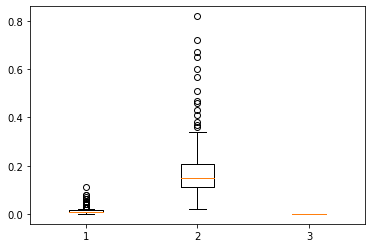

From left to right:
08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1
08-13-11-15-00-FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE



In [30]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
        '08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1',
        '08-13-11-15-00-FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE',
        '08-14-08-54-19-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv4Dense3-MSE'
    ]
)

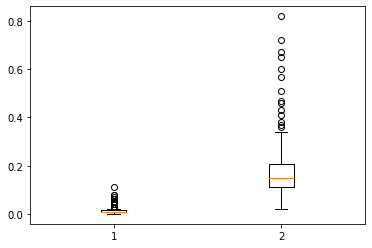

From left to right:
08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1
08-13-11-15-00-FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE


In [31]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
        '08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1',
        '08-13-11-15-00-FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE',
    ]
)

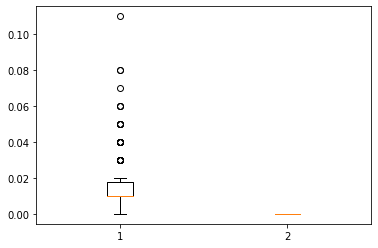

From left to right:
08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1



In [32]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
    '08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1',
    '08-14-08-54-19-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv4Dense3-MSE',
    ]
)